In [1]:
from _element import feature_control as ft_c

In [2]:
from _usecase import algorithm_prophet as prpt

In [3]:
from _element import calculations as calc

In [4]:
import pandas as pd

In [5]:
from datetime import datetime

In [6]:
from _element import varr

In [7]:
INPUT_FILENAME= 'KPP일별_반납회수(13_17)_raw.xlsx'

In [8]:
df_raw= ft_c.xlsx_opener(varr.PJ_DIR+varr.DF_DIR, INPUT_FILENAME)

In [9]:
df_temp= ft_c.xlsx_opener(varr.PJ_DIR+varr.TEMP_DATA_DIR, 'temp_data_merged.xlsx')

In [10]:
y_col= df_raw.columns.values.tolist()

In [11]:
try:
    y_col.remove('ds')
except ValueError:
    pass

In [12]:
y_col

['y_sum']

In [13]:
x_col= df_temp.columns.values.tolist()

In [14]:
x_col

['ds', 'temp_max', 'temp_min', 'rain_amount']

In [15]:
df_raw['ds']= pd.to_datetime(df_raw['ds'], box=True, format= '%Y/%m/%d', exact=True)

In [16]:
df_temp['ds']= pd.to_datetime(df_temp['ds'], box=True, format= '%Y/%m/%d', exact=True)

In [17]:
df_raw= pd.merge(df_raw, df_temp, how='inner', on='ds')

In [18]:
df_raw.head()

,ds,y_sum,temp_max,temp_min,rain_amount
0,2013-01-01,17399,-0.4,-12.900000,3.0
1,2013-01-02,65748,-9.4,-16.200001,0.0
2,2013-01-03,73139,-9.6,-15.300000,0.0
3,2013-01-04,78096,-6.2,-13.700000,0.0
4,2013-01-05,64780,-2.2,-10.900000,0.0


In [19]:
df_weekday_0= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==0]
df_weekday_1= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==1]
df_weekday_2= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==2]
df_weekday_3= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==3]
df_weekday_4= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==4]
df_weekday_5= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==5]
df_weekday_6= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==6]

In [20]:
result_dict= {}
for y in y_col:
    result_dict[y]= {
                    'mon': prpt.Bayseian2(df_weekday_0, varr.FORECASTDAY, y, x_col, 'week'),\
                    'tue': prpt.Bayseian2(df_weekday_1, varr.FORECASTDAY, y, x_col, 'week'),\
                    'wed': prpt.Bayseian2(df_weekday_2, varr.FORECASTDAY, y, x_col, 'week'),\
                    'thu': prpt.Bayseian2(df_weekday_3, varr.FORECASTDAY, y, x_col, 'week'),\
                    'pri': prpt.Bayseian2(df_weekday_4, varr.FORECASTDAY, y, x_col, 'week'),\
                    'sat': prpt.Bayseian2(df_weekday_5, varr.FORECASTDAY, y, x_col, 'week'),\
                    'sun': prpt.Bayseian2(df_weekday_6, varr.FORECASTDAY, y, x_col, 'week'),\
                    }

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [21]:
merged_dict={}
for y in y_col:
    merged_dict[y]={'future': 
                    pd.concat([result_dict[y]['mon']['future'],\
                              result_dict[y]['tue']['future'],\
                              result_dict[y]['wed']['future'],\
                              result_dict[y]['thu']['future'],\
                              result_dict[y]['pri']['future'],\
                              result_dict[y]['sat']['future'],\
                              result_dict[y]['sun']['future']],\
                              axis= 0).sort_values(by='ds', axis=0),
                   'forecastProphetTable':
                    pd.concat([result_dict[y]['mon']['forecastProphetTable'],\
                              result_dict[y]['tue']['forecastProphetTable'],\
                              result_dict[y]['wed']['forecastProphetTable'],\
                              result_dict[y]['thu']['forecastProphetTable'],\
                              result_dict[y]['pri']['forecastProphetTable'],\
                              result_dict[y]['sat']['forecastProphetTable'],\
                              result_dict[y]['sun']['forecastProphetTable']],\
                              axis= 0).sort_values(by='ds', axis=0)
                   }

In [22]:
forecast_dict={}
print(INPUT_FILENAME)
for y in y_col:
    merged_dict[y]['future']['ds']= pd.to_datetime(merged_dict[y]['future']['ds'], box=True, format= '%Y/%m/%d', exact=True)
    merged_dict[y]['forecastProphetTable']['ds']= pd.to_datetime(merged_dict[y]['forecastProphetTable']['ds'], box=True, format= '%Y/%m/%d', exact=True)
    forecast_dict[y]= prpt.extract_info_from(merged_dict[y]['future'], merged_dict[y]['forecastProphetTable'], varr.FORECASTDAY)
    forecast_dict[y]['result_df']= pd.merge(forecast_dict[y]['result_df'], df_raw[['ds', y]], how='inner', on='ds')
    print('RMSE with segment '+str(y)+': '+str(calc.rms_error(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('MAPE with segment '+str(y)+': '+str(calc.map_error(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('MAPE_with_std with segment '+str(y)+': '+str(calc.map_error_with_std(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('MAPE_div_std with segment '+str(y)+': '+str(calc.map_error_div_std(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('sMAPE of company code '+str(y)+': '+str(calc.smap_error(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print(forecast_dict[y]['result_df'].head())
    ft_c.save_as_xlsx(varr.PJ_DIR+varr.DF_DIR, forecast_dict[y]['result_df'], INPUT_FILENAME, '_seg'+str(y)+'withweekday')
    print('\n')

KPP일별_반납회수(13_17)_raw.xlsx
RMSE with segment y_sum: 33059.1457865
MAPE with segment y_sum: inf
MAPE_with_std with segment y_sum: 33.0196361569
MAPE_div_std with segment y_sum: 82.5960076751
sMAPE of company code y_sum: 14.0263878998
          ds  temp_max  temp_min  rain_amount           yhat   y_sum
0 2017-11-20       3.7      -4.0          0.2  114688.970710  109169
1 2017-11-21       6.8       0.4          0.5  112642.345474  110799
2 2017-11-22       9.5      -0.8          0.0  113689.213373  109494
3 2017-11-23       4.3      -0.6          0.8  109805.775178  106295
4 2017-11-24       2.9      -2.5          0.1  112096.959408  106479




C:\Nextop\nextop-engine\nextop_engine\_element\calculations.py:11: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


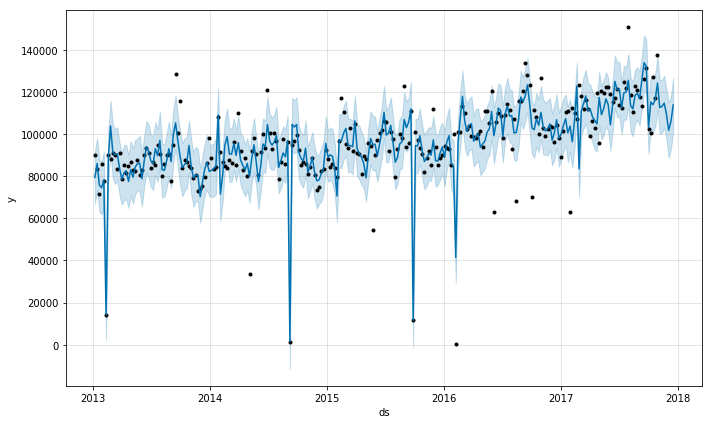

In [24]:
result_dict['y_sum']['mon']['model'].plot(result_dict['y_sum']['mon']['forecastProphetTable'])

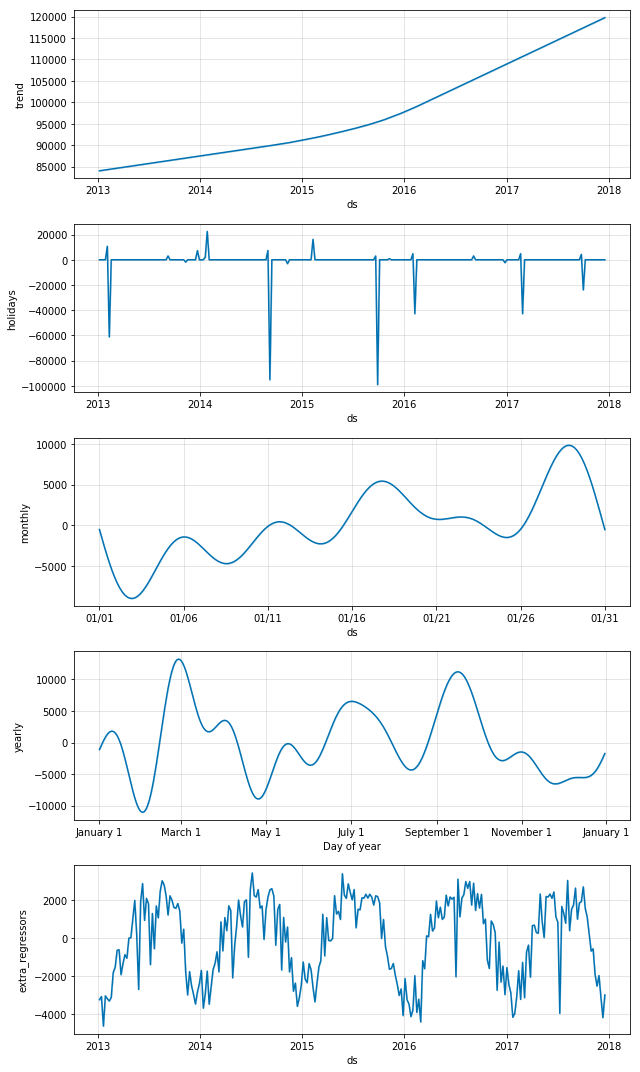

In [31]:
result_dict['y_sum']['mon']['model'].plot_components(result_dict['y_sum']['mon']['forecastProphetTable'])

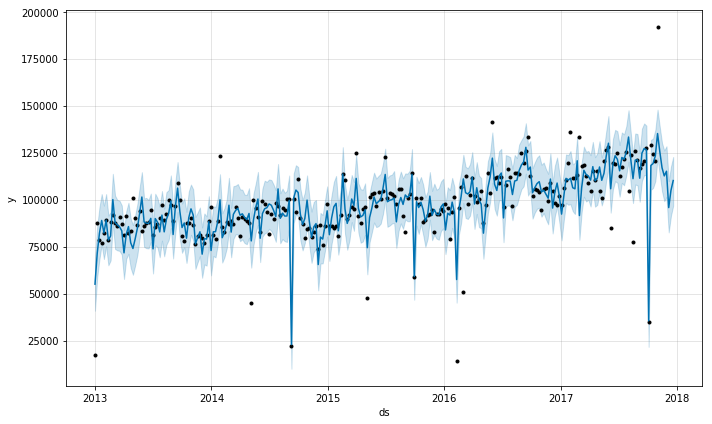

In [25]:
result_dict['y_sum']['tue']['model'].plot(result_dict['y_sum']['tue']['forecastProphetTable'])

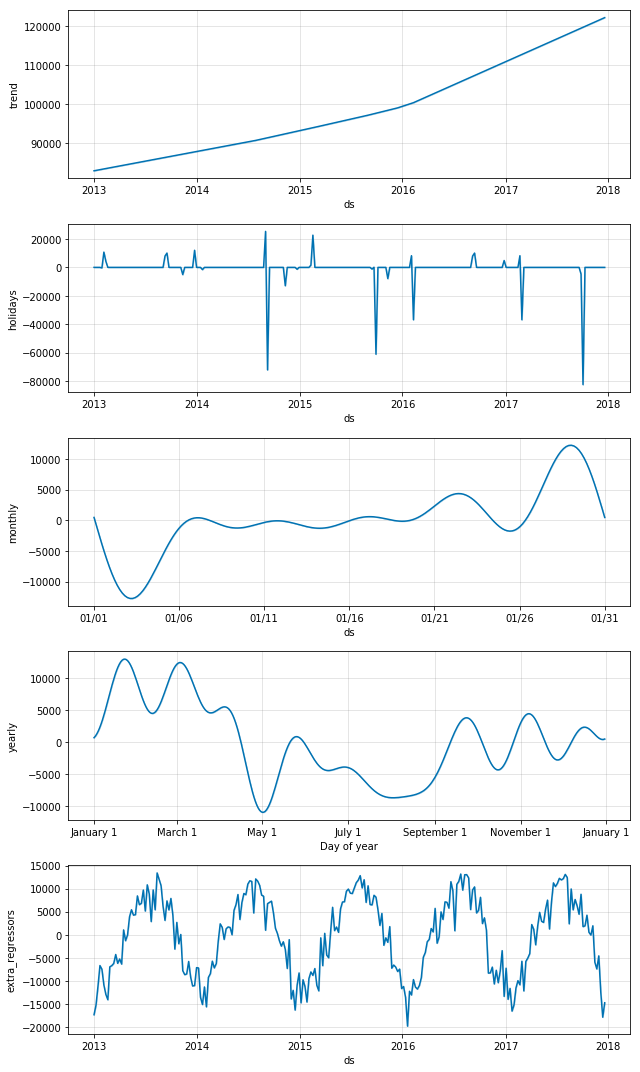

In [32]:
result_dict['y_sum']['tue']['model'].plot_components(result_dict['y_sum']['tue']['forecastProphetTable'])

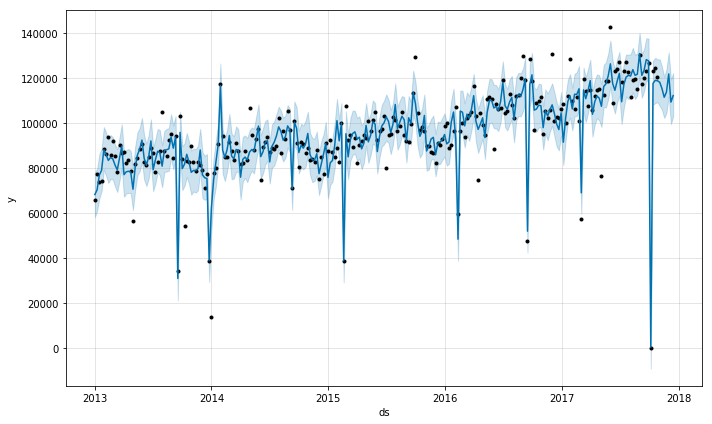

In [26]:
result_dict['y_sum']['wed']['model'].plot(result_dict['y_sum']['wed']['forecastProphetTable'])

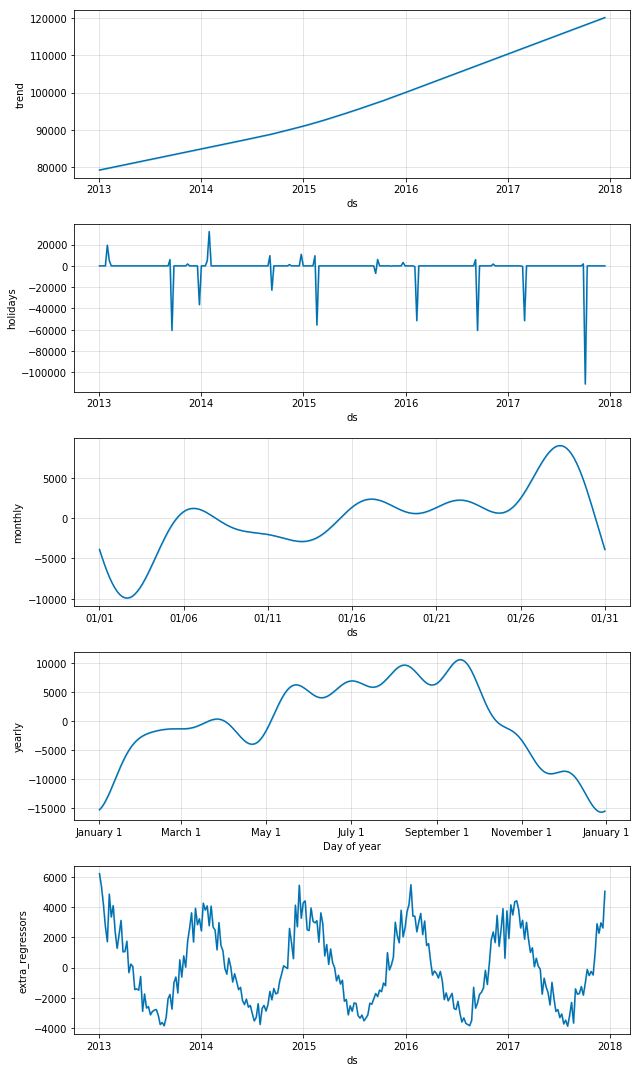

In [33]:
result_dict['y_sum']['wed']['model'].plot_components(result_dict['y_sum']['wed']['forecastProphetTable'])

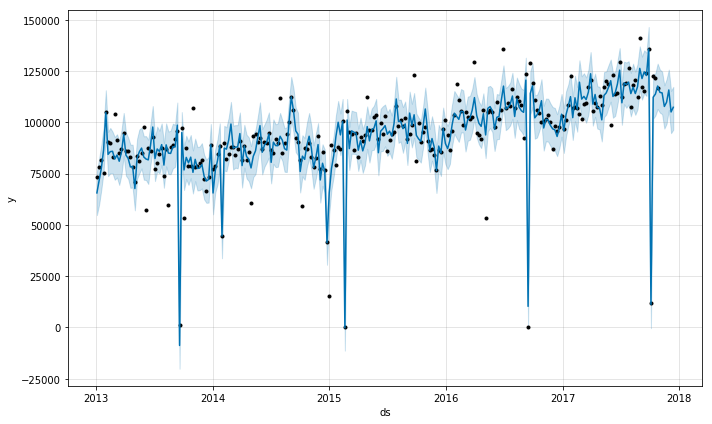

In [27]:
result_dict['y_sum']['thu']['model'].plot(result_dict['y_sum']['thu']['forecastProphetTable'])

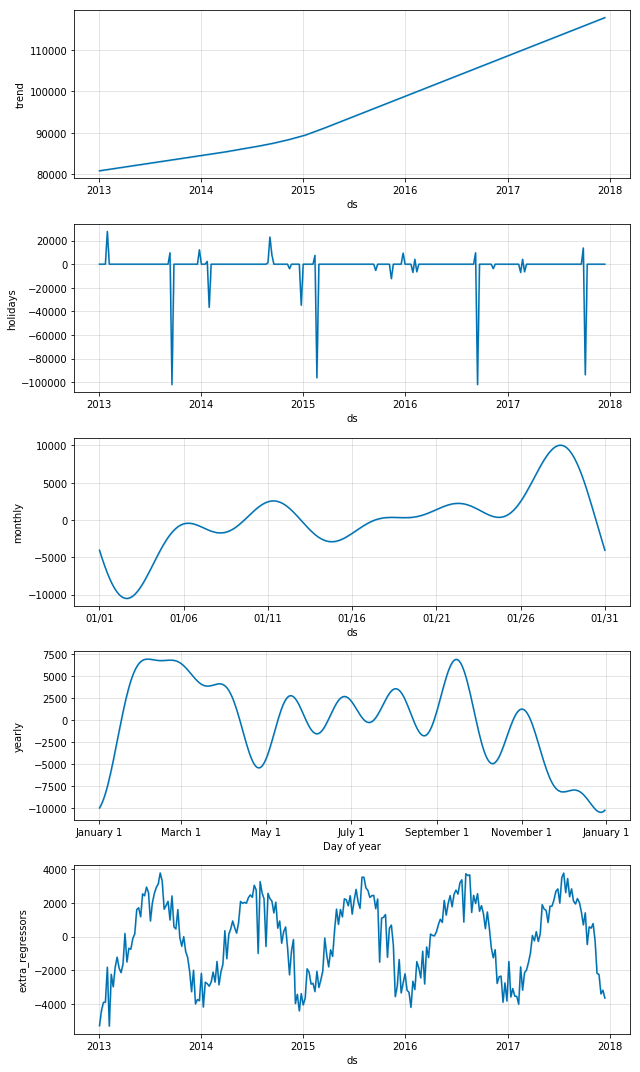

In [34]:
result_dict['y_sum']['thu']['model'].plot_components(result_dict['y_sum']['thu']['forecastProphetTable'])

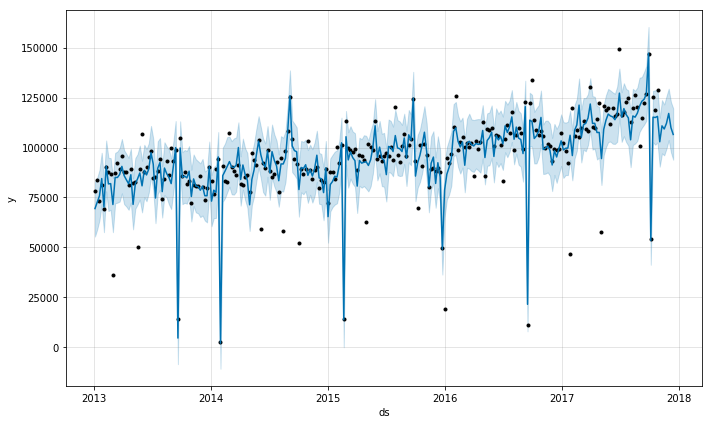

In [28]:
result_dict['y_sum']['pri']['model'].plot(result_dict['y_sum']['pri']['forecastProphetTable'])

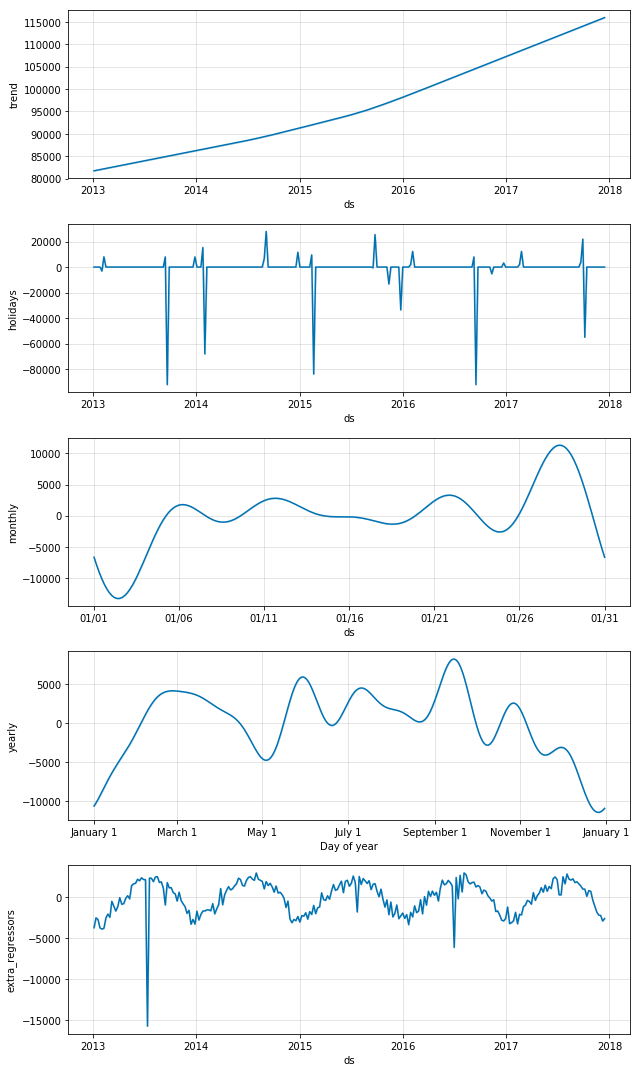

In [35]:
result_dict['y_sum']['pri']['model'].plot_components(result_dict['y_sum']['pri']['forecastProphetTable'])

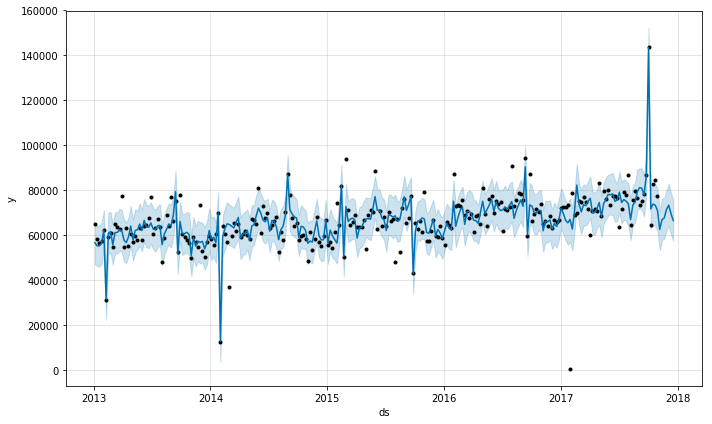

In [29]:
result_dict['y_sum']['sat']['model'].plot(result_dict['y_sum']['sat']['forecastProphetTable'])

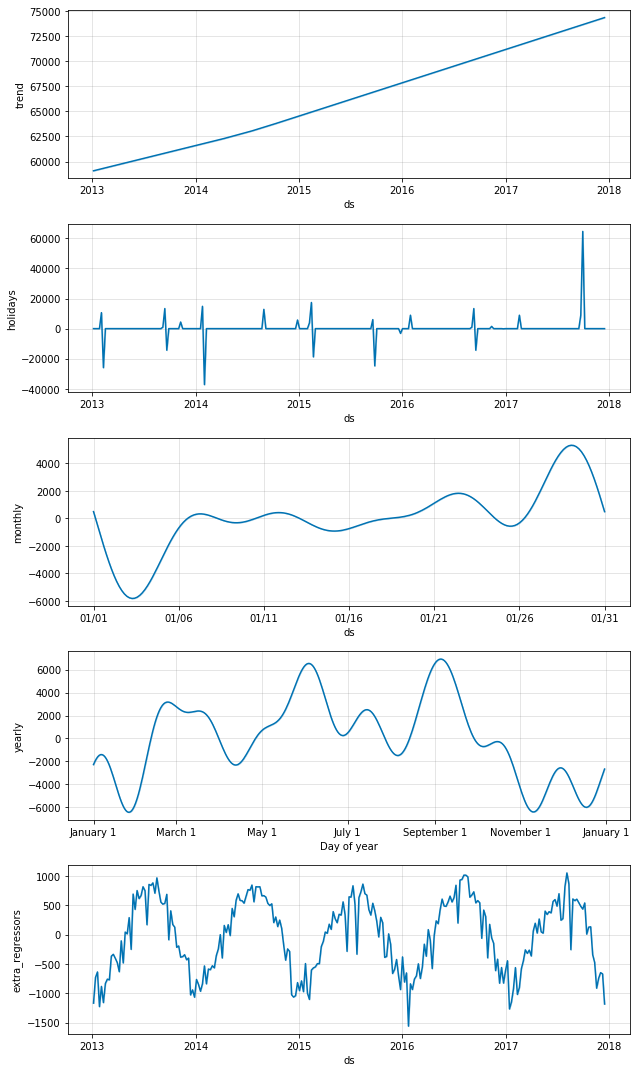

In [36]:
result_dict['y_sum']['sat']['model'].plot_components(result_dict['y_sum']['sat']['forecastProphetTable'])

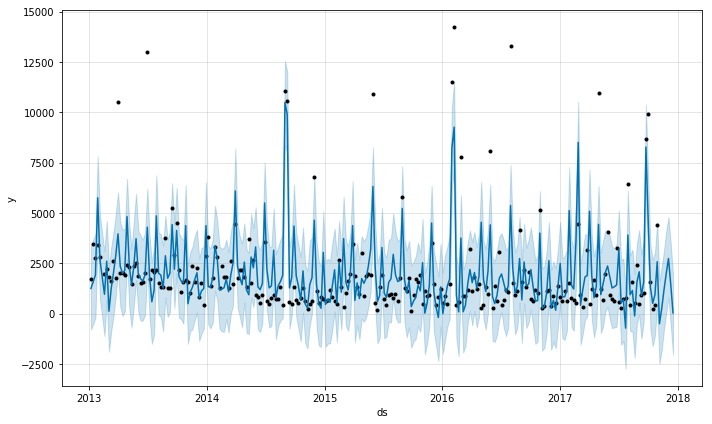

In [23]:
result_dict['y_sum']['sun']['model'].plot(result_dict['y_sum']['sun']['forecastProphetTable'])

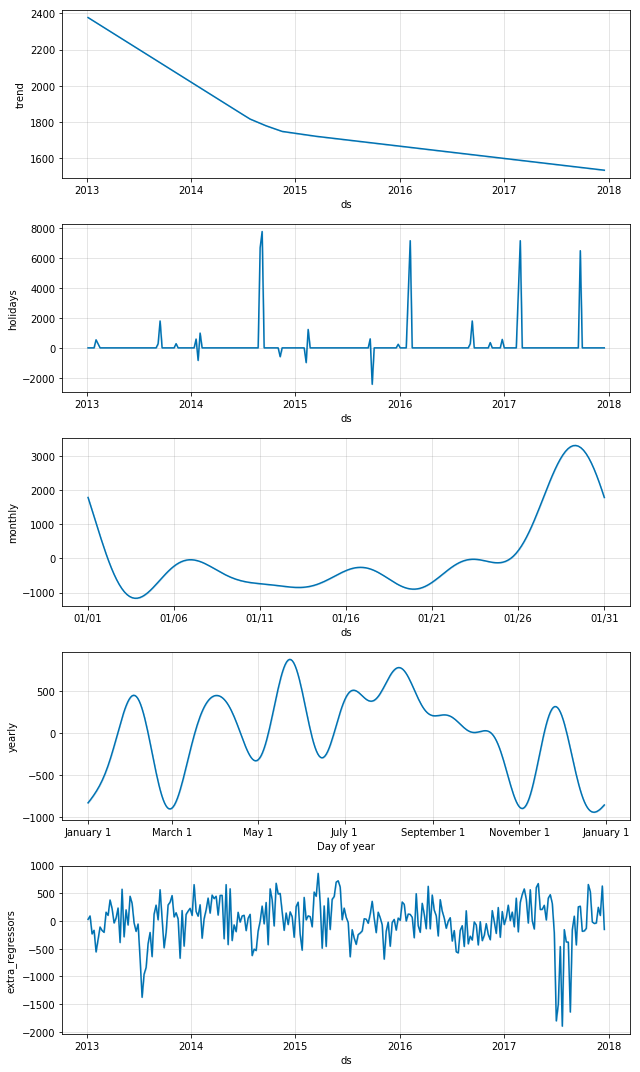

In [37]:
result_dict['y_sum']['sun']['model'].plot_components(result_dict['y_sum']['sun']['forecastProphetTable'])

In [24]:
# result_dict[y]['sun']['model'].plot_components(result_dict[y]['sun']['forecastProphetTable'])